# Stroke data basic EDA and predictions

Welcome!<br>
&emsp;&emsp;In this notebook we will take a look at the dataset from Kaggle containing information about patients and whether they had stroke or not. We will do basic exploration of this dataset and try to predict if a new patient is likely to get a stroke or not.<br>
&emsp;&emsp;In our predictions we will use Logistic Regression, Naive Bayes, K-Nearest Neighbours, Decision Tree and Linear Discriminant Analysis using Scikit-learn library.

Table of content:<br><br>
    [1. The Data](#data)<br>
    [2. The Vizualization](#viz)<br>
    [3. The Preprocessing](#pre)<br>
        &emsp;[3.1. Dummies](#dummies)<br>
        &emsp;[3.2. Split](#split)<br>
        &emsp;[3.3. Normalization](#norm)<br>
        &emsp;[3.4. SMOTE](#smote)<br>
    [4. The Models](#models)<br>
    [5. Grid search](#grid)<br>

In [56]:
# Libraries

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, plot_roc_curve, \
precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, precision_recall_curve

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(10, 5)})

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv('healthcare-dataset-stroke-data.csv')

### The data
<a id='data'></a>

In [3]:
raw_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
raw_data.shape

(5110, 12)

We have 5110 entries in our dataset describing patient's age, health status, marital status, type of work, type of residence, wheter he smokes or not and had or did not a stroke.

In [5]:
raw_data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
raw_data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Filling missing values in BMI column with mean:

In [8]:
df = raw_data.copy()
df.drop('id', axis=1, inplace=True)
df = df.fillna(df['bmi'].mean())
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Data Visualization
<a id='viz'></a>

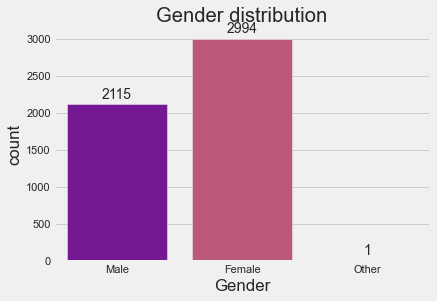

In [9]:
plt.style.use('fivethirtyeight')
g = sns.countplot(x=df['gender'], palette='plasma')
for p in g.patches:
    g.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., \
                                               p.get_height()), ha = 'center', va = 'center', \
                                               xytext = (0, 10), textcoords = 'offset points')
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

Females are a majority in our dataset.

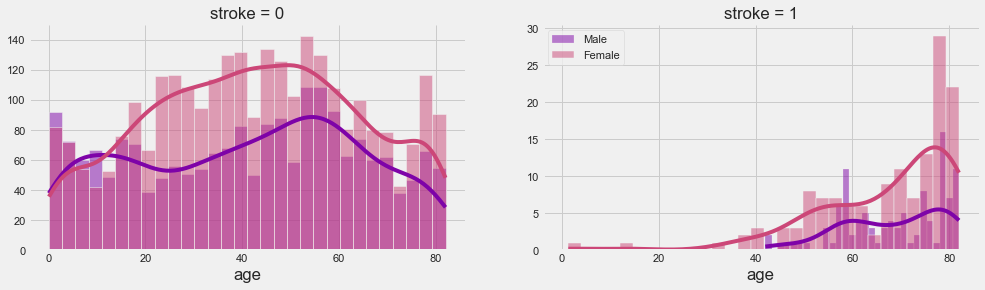

In [10]:
plt.style.use('fivethirtyeight')
g = sns.FacetGrid(df, col='stroke', hue='gender', palette='plasma', sharey=False)
g.map(sns.histplot, "age", bins=30, kde=True)
plt.legend()
g.fig.set_size_inches(15, 5)

We can see that stroke affects older people which was to be expected, although stroke occurs across every age group, including infants.

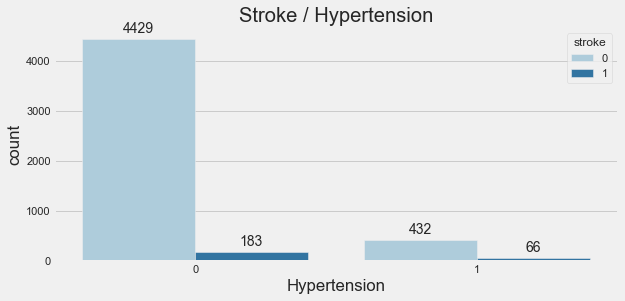

In [11]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9, 4))
g = sns.countplot(x=df['hypertension'], hue=df['stroke'], palette='Paired')
for p in g.patches:
    g.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., \
                                               p.get_height()), ha = 'center', va = 'center', \
                                               xytext = (0, 10), textcoords = 'offset points')
plt.title('Stroke / Hypertension')
plt.xlabel('Hypertension')
plt.show()

Stroke occurs more often in cases of hypertansion (13%) comparing to patients without hypertension (4%).  

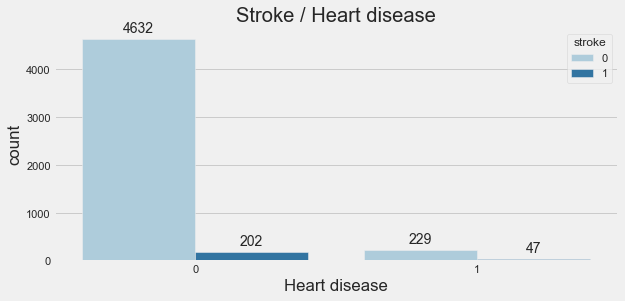

In [12]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9, 4))
g = sns.countplot(x=df['heart_disease'], hue=df['stroke'], palette='Paired')
for p in g.patches:
    g.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., \
                                               p.get_height()), ha = 'center', va = 'center', \
                                               xytext = (0, 10), textcoords = 'offset points')
plt.title('Stroke / Heart disease')
plt.xlabel('Heart disease')
plt.show()

Similarly to hypertension stroke occurs more oftes in cases of heart disease (17%) compared to absence of such (4%).

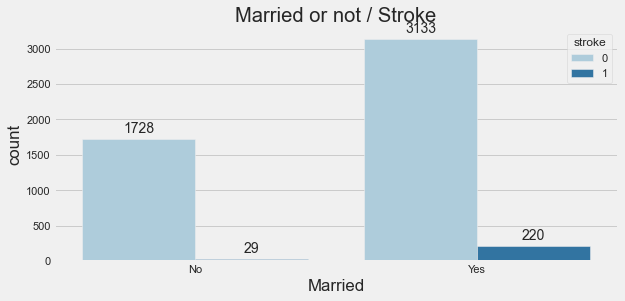

In [13]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9, 4))
g = sns.countplot(x=df['ever_married'], hue=df['stroke'], palette='Paired', order=['No', 'Yes'])
for p in g.patches:
    g.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., 
                                        p.get_height()), ha = 'center', va = 'center', 
                                        xytext = (0, 10), textcoords = 'offset points')
plt.title('Married or not / Stroke')
plt.xlabel('Married')
plt.show()

Married people tend to be more affected by stroke.

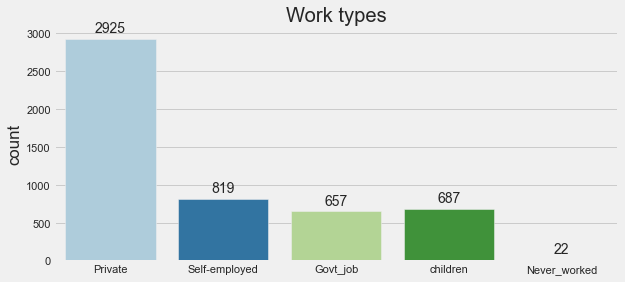

In [14]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9, 4))
g = sns.countplot(x=df['work_type'], palette='Paired')
for p in g.patches:
    g.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., \
                                               p.get_height()), ha = 'center', va = 'center', \
                                               xytext = (0, 10), textcoords = 'offset points')
plt.title('Work types')
plt.xlabel('')
plt.show()

Most of people in our dataset works in a private companies.

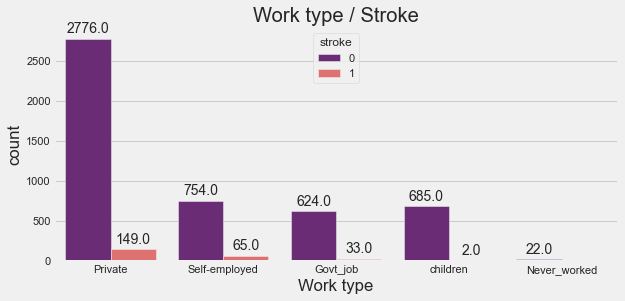

In [15]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9, 4))
g = sns.countplot(x=df['work_type'], hue=df['stroke'], palette='magma')
for p in g.patches:
    g.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., \
                                               p.get_height()), ha = 'center', va = 'center', \
                                               xytext = (0, 10), textcoords = 'offset points')
plt.title('Work type / Stroke')
plt.xlabel('Work type')
plt.show()

In our dataset stroke occurs more amongst self employed people (7%) rather than people working for private companies (5%) or government (5%).

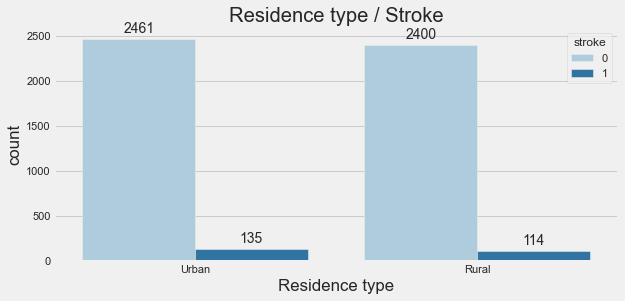

In [16]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9, 4))
g = sns.countplot(x=df['Residence_type'], hue=df['stroke'], palette='Paired')
for p in g.patches:
    g.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., \
                                               p.get_height()), ha = 'center', va = 'center', \
                                               xytext = (0, 10), textcoords = 'offset points')
plt.title('Residence type / Stroke')
plt.xlabel('Residence type')
plt.show()

Residence type seems to have very little impact.

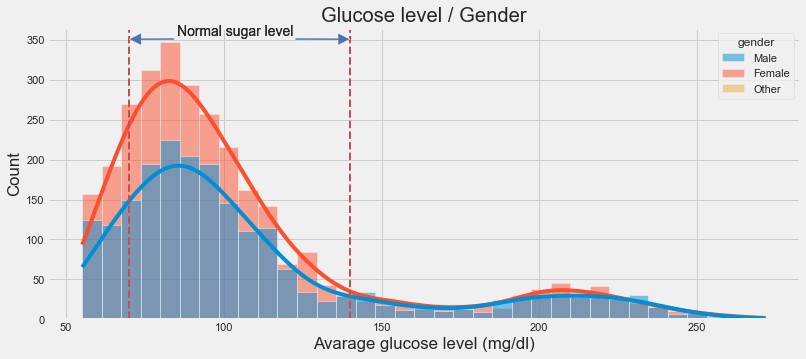

In [17]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 5))
sns.histplot(x=df["avg_glucose_level"], hue=df['gender'], bins=35, kde=True)
plt.axvline(x=140, linewidth=2, color='r', ls='--')
plt.axvline(x=70, linewidth=2, color='r', ls='--')
plt.annotate('Normal sugar level', xy=(140, 351), arrowprops={'width': 2}, xytext=(85, 355), )
plt.annotate('Normal sugar level', xy=(70, 351), arrowprops={'width': 2}, xytext=(85, 355), )
plt.title('Glucose level / Gender')
plt.xlabel('Avarage glucose level (mg/dl)')
plt.show()

Glucose level should be interpreted individually for every person, but generally for a healthy pearson it should be between 70 and 140 mg/dl.

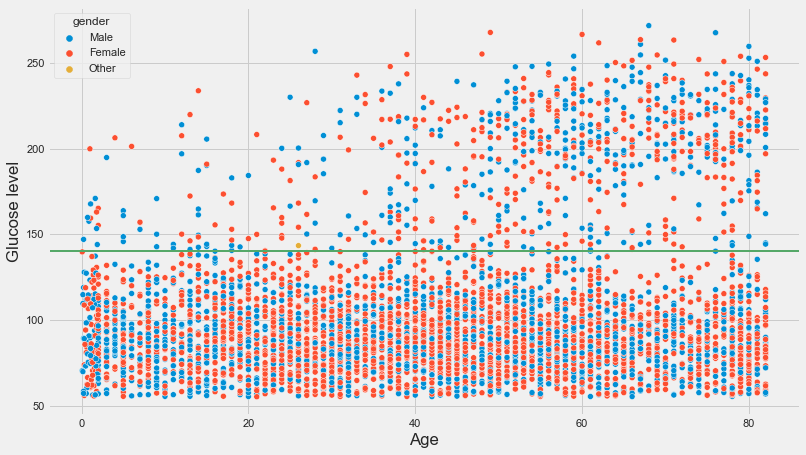

In [18]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 7))
sns.scatterplot(x='age', y='avg_glucose_level', data=df, hue='gender')
plt.axhline(y=140, linewidth=2, color='g', ls='-')
plt.ylabel('Glucose level')
plt.xlabel('Age')
plt.show()

In [19]:
len(df[df['avg_glucose_level'] > 140])

821

821 of our patients can be classified as overweight judging by glucose level.

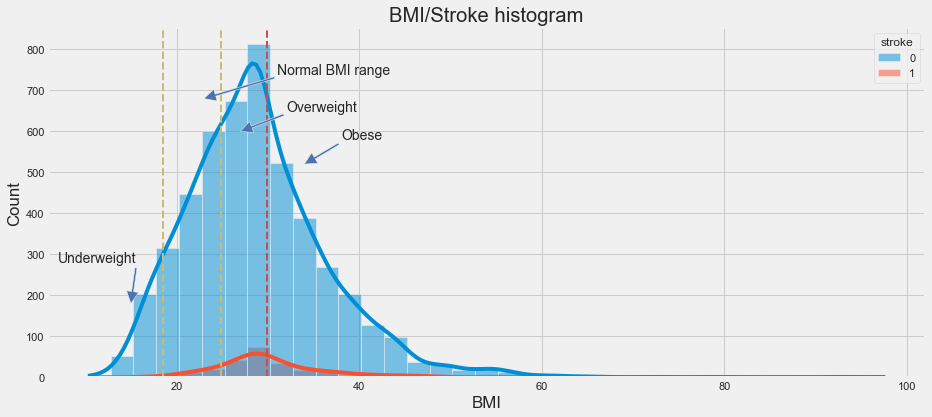

In [20]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(14, 6))
sns.histplot(x=df["bmi"], hue=df['stroke'], bins=35, kde=True)
plt.axvline(x=18.5, linewidth=2, color='y', ls='--')
plt.axvline(x=24.9, linewidth=2, color='y', ls='--')
plt.annotate('Underweight', xy=(15, 180), arrowprops={'width': 2},  xytext=(7, 280), )
plt.annotate('Normal BMI range', xy=(23, 680), arrowprops={'width': 2},  xytext=(31, 740), )
plt.axvline(x=29.9, linewidth=2, color='r', ls='--')
plt.annotate('Overweight', xy=(27, 600), arrowprops={'width': 2},  xytext=(32, 650), )
plt.annotate('Obese', xy=(34, 520), arrowprops={'width': 2},  xytext=(38, 580), )
plt.title('BMI/Stroke histogram')
plt.xlabel('BMI')
plt.show()

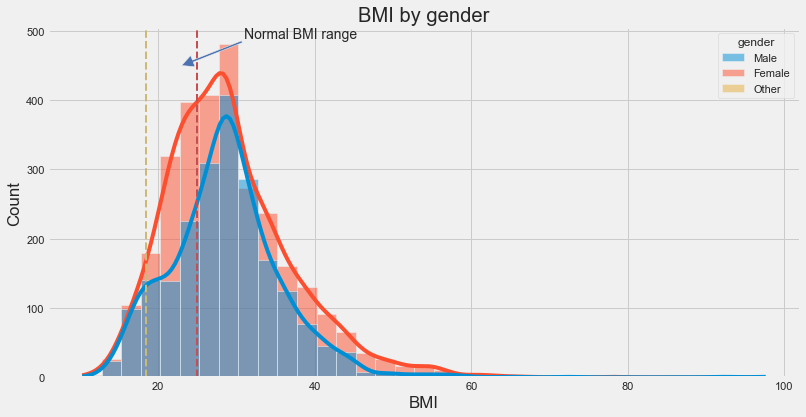

In [21]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 6))
sns.histplot(x=df["bmi"], hue=df['gender'], bins=35, kde=True)
plt.axvline(x=18.5, linewidth=2, color='y', ls='--')
plt.axvline(x=24.9, linewidth=2, color='r', ls='--')
plt.annotate('Normal BMI range', xy=(23, 450), arrowprops={'width': 2},  xytext=(31, 490), )
plt.title('BMI by gender')
plt.xlabel('BMI')
plt.show()

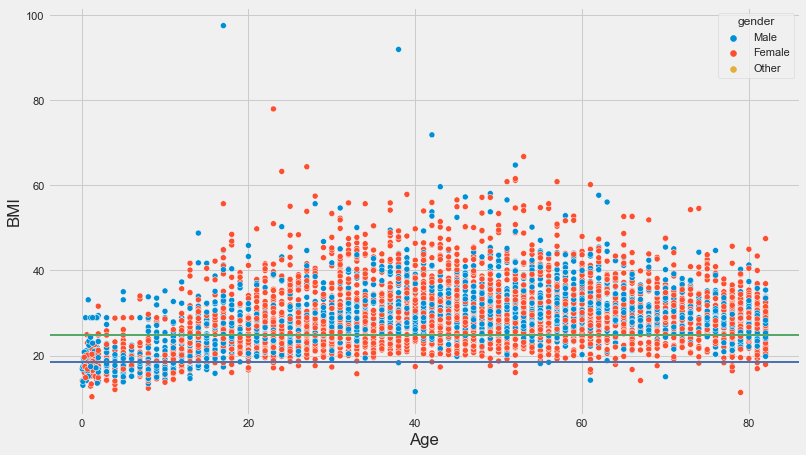

In [22]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 7))
sns.scatterplot(x='age', y='bmi', data=df, hue='gender')
plt.axhline(y=24.9, linewidth=2, color='g', ls='-')
plt.axhline(y=18.5, linewidth=2, color='b', ls='-')
plt.ylabel('BMI')
plt.xlabel('Age')
plt.show()

In [23]:
len(df[df['bmi']>25])

3503

BMI below 18,5 falls into underweight range (blue line on the scatter plot).<br>
BMI in range 18.5 - 25 is considered normal.<br>
BMI of 25.0 (green line on the scatter plot) to <30 falls within the overweight range and over 30 is a obesity range.

As we can see most of our patients may be classified as overweight.

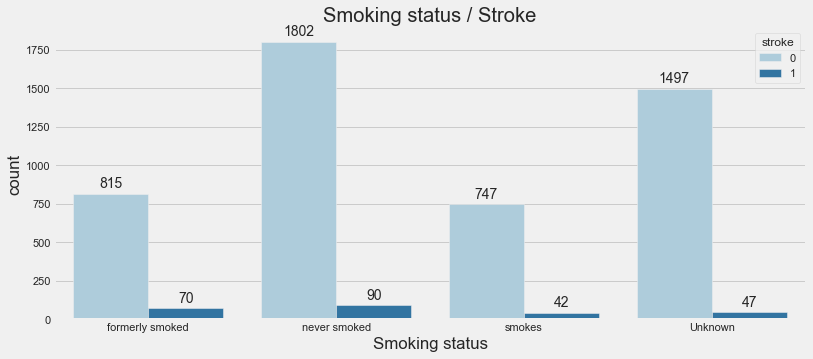

In [24]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 5))
g = sns.countplot(x=df['smoking_status'], hue=df['stroke'], palette='Paired')
for p in g.patches:
    g.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., \
                                               p.get_height()), ha = 'center', va = 'center', \
                                               xytext = (0, 10), textcoords = 'offset points')
plt.title('Smoking status / Stroke')
plt.xlabel('Smoking status')
plt.show()

Stroke occurences amongst smokers/non-smokers:<br>
People that formerly smoked: 7%<br> Never smoked: 4%<br> Smokes 5%<br>
<br>
Unfortunatelly we can't interpret the 'Unknown' status so those numbers don't reflect the whole situation.

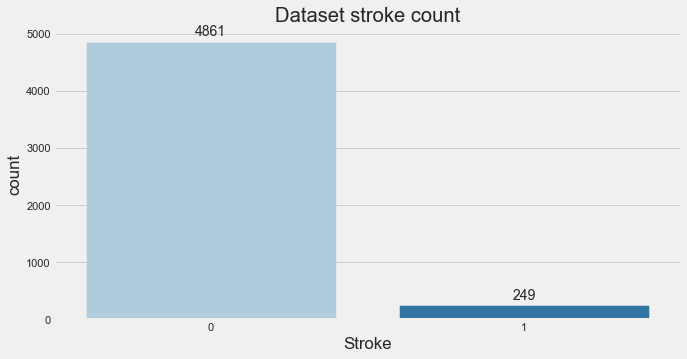

In [25]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 5))
g = sns.countplot(x=df['stroke'], palette='Paired')
for p in g.patches:
    g.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., \
                                               p.get_height()), ha = 'center', va = 'center', \
                                               xytext = (0, 10), textcoords = 'offset points')
plt.title('Dataset stroke count')
plt.xlabel('Stroke')
plt.show()

Total number of stroke occurences in this dataset. As we can see most of our patients did not suffer from stroke.

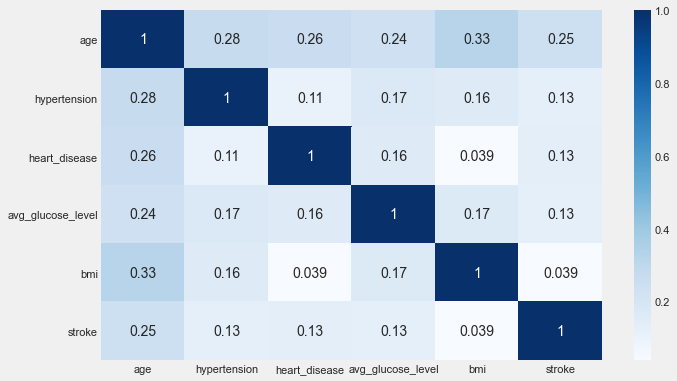

In [26]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 6))
to_corr = df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']].corr()
plt.style.use('fivethirtyeight')
sns.heatmap(to_corr, cmap='Blues', annot=True)
plt.show()

From the plot above we can see that age and BMI are heavier corelated with stroke than other variables.

This sums up our exploration, let's get into the modeling.
***

# Preprocessing
<a id='pre'></a>

### Dummies
<a id='dummies'></a>

It is always better to convert categorical variables into numeric format because machine learning algorithms can't interpret words. We will use Pandas 'get_dummies' method for that.<br><br> Our data before encoding:

In [27]:
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1


In [28]:
gender = pd.get_dummies(df['gender'], drop_first=True)
married = pd.get_dummies(df['ever_married'], drop_first=True)
work = pd.get_dummies(df['work_type'])
residence = pd.get_dummies(df['Residence_type'], drop_first=True)
smoking = pd.get_dummies(df['smoking_status'])

In [29]:
df_model = df.copy()
df_model.drop(['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis=1, inplace=True)
df_model = pd.concat([df_model, gender, married, work, residence, smoking], axis=1)
df_model.rename(columns={'Yes': 'Married'}, inplace=True)

Data after encoding:

In [30]:
df_model.head(3)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Male,Other,Married,Govt_job,Never_worked,Private,Self-employed,children,Urban,Unknown,formerly smoked,never smoked,smokes
0,67.0,0,1,228.69,36.600000,1,1,0,1,0,0,1,0,0,1,0,1,0,0
1,61.0,0,0,202.21,28.893237,1,0,0,1,0,0,0,1,0,0,0,0,1,0
2,80.0,0,1,105.92,32.500000,1,1,0,1,0,0,1,0,0,0,0,0,1,0


### Split
 
<a id='split'></a>

In [31]:
X = df_model.drop('stroke', axis=1)
y = df_model['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

### Normalization
<a id='norm'></a>

The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. That helps machine learning algorithms to better understand dependencies between values.

In [32]:
normalizer= MinMaxScaler()

X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

##### SMOTE
<a id='smote'></a>

Since we have unbalanced dataset we will use SMOTE (Synthetic Minority Oversampling TEchnique) to oversample the minority class (in our case '1', which is an occurence of stroke).

*'SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.'*

Source: Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.

In [33]:
y_train.value_counts()

0    3890
1     198
Name: stroke, dtype: int64

In [34]:
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [35]:
y_train_smote.value_counts()

1    3890
0    3890
Name: stroke, dtype: int64

### Models
<a id='models'></a>

We create a list of models and loop through it fitting, training models on our data and printing the results. We will as well define a function that will help us visualize some aspects of the outcomes.<br>
The last step is to store the results in a dataframe to better compare the proedictions of our models side by side.

In [58]:
models = [['Logistic Regression', LogisticRegression()], 
               ['Naive Bayes (GNB)', GaussianNB()], 
               ['K-Nearest Neighbours', KNeighborsClassifier()],
               ['Decision Tree', DecisionTreeClassifier()], 
               ['LDA', LinearDiscriminantAnalysis()]]

In [37]:
def precision_recall_threshold_plot(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "g--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "b", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.title('Precision/Recall vs Threshold')
    plt.ylim([0, 1])
    plt.show()


Results for LogisticRegression()

Confusion matrix:

 [[719 252]
 [  8  43]] 

Classification report:

               precision    recall  f1-score   support

           0       0.99      0.74      0.85       971
           1       0.15      0.84      0.25        51

    accuracy                           0.75      1022
   macro avg       0.57      0.79      0.55      1022
weighted avg       0.95      0.75      0.82      1022



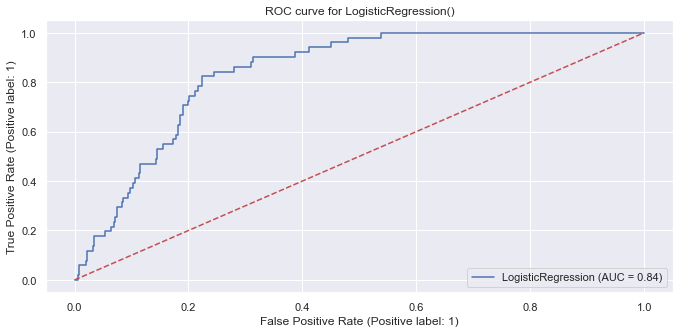

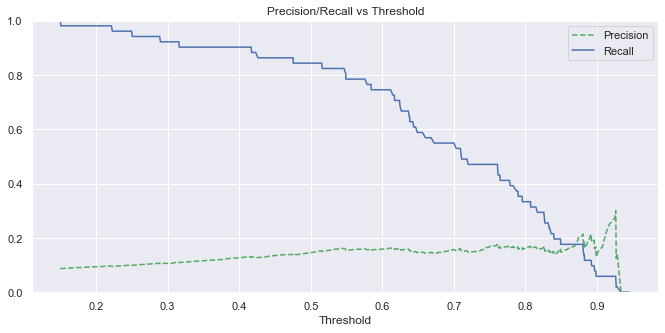


Results for GaussianNB()

Confusion matrix:

 [[293 678]
 [  0  51]] 

Classification report:

               precision    recall  f1-score   support

           0       1.00      0.30      0.46       971
           1       0.07      1.00      0.13        51

    accuracy                           0.34      1022
   macro avg       0.53      0.65      0.30      1022
weighted avg       0.95      0.34      0.45      1022



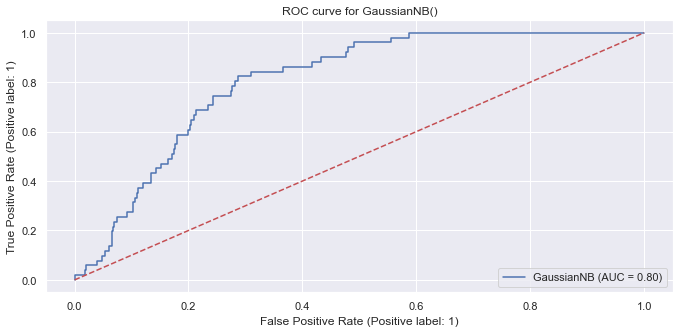

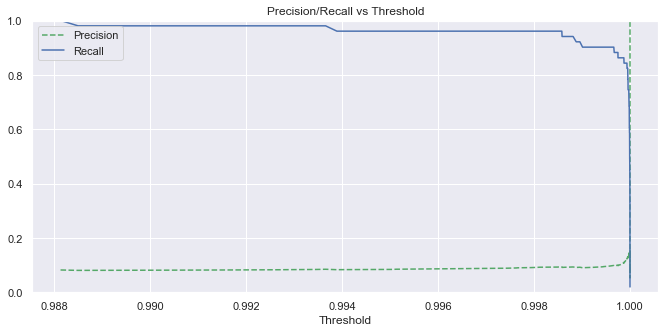


Results for KNeighborsClassifier()

Confusion matrix:

 [[825 146]
 [ 29  22]] 

Classification report:

               precision    recall  f1-score   support

           0       0.97      0.85      0.90       971
           1       0.13      0.43      0.20        51

    accuracy                           0.83      1022
   macro avg       0.55      0.64      0.55      1022
weighted avg       0.92      0.83      0.87      1022



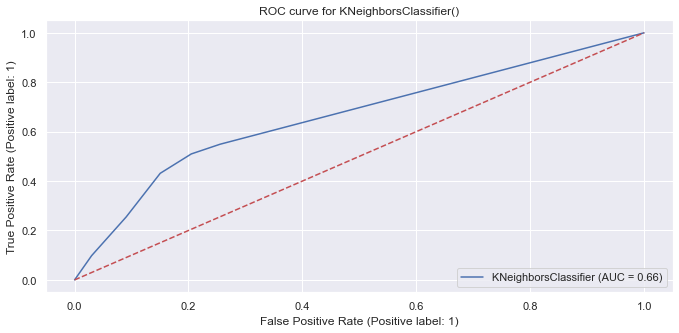

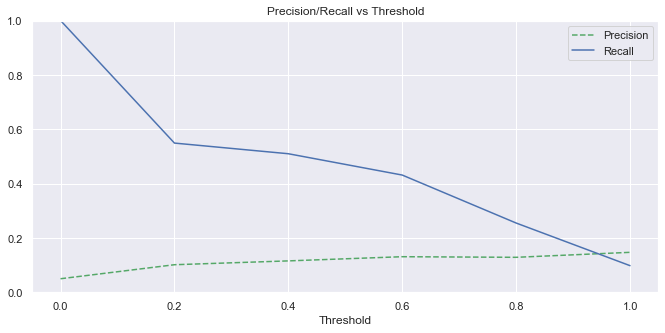


Results for DecisionTreeClassifier()

Confusion matrix:

 [[874  97]
 [ 34  17]] 

Classification report:

               precision    recall  f1-score   support

           0       0.96      0.90      0.93       971
           1       0.15      0.33      0.21        51

    accuracy                           0.87      1022
   macro avg       0.56      0.62      0.57      1022
weighted avg       0.92      0.87      0.89      1022



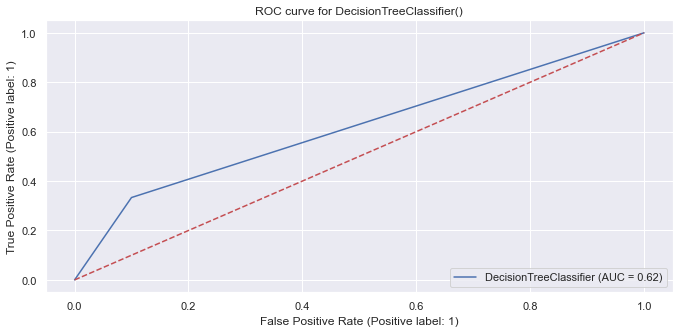

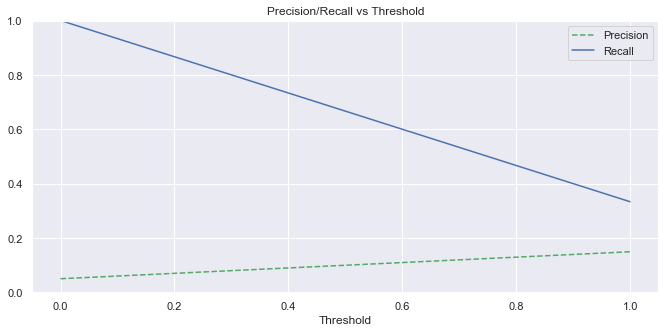


Results for LinearDiscriminantAnalysis()

Confusion matrix:

 [[707 264]
 [  7  44]] 

Classification report:

               precision    recall  f1-score   support

           0       0.99      0.73      0.84       971
           1       0.14      0.86      0.25        51

    accuracy                           0.73      1022
   macro avg       0.57      0.80      0.54      1022
weighted avg       0.95      0.73      0.81      1022



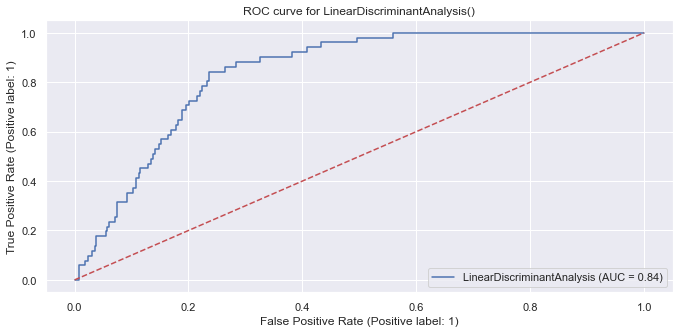

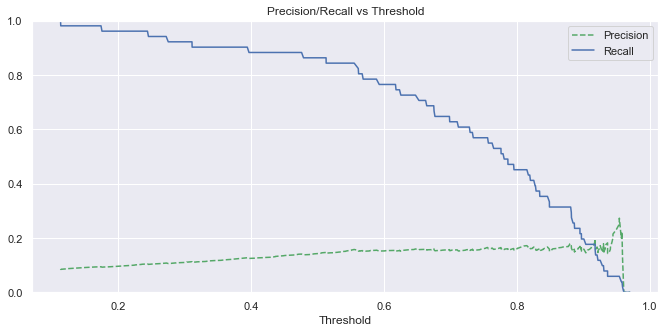

In [59]:
results = {}

for i in range(0, len(models)):
    
    clf = models[i][1]
    clf.fit(X_train_smote, y_train_smote)
    clf_pred = clf.predict(X_test)
    clf_proba = clf.predict_proba(X_test)[:, 1]
    
    print(f'\nResults for {clf}\n')
    print('Confusion matrix:\n\n', confusion_matrix(y_test, clf_pred), '\n')
    print('Classification report:\n\n', classification_report(y_test, clf_pred))
    
    plot_roc_curve(clf, X_test, y_test)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f'ROC curve for {clf}')
    plt.show()
    
    precisions_clf, recalls_clf, thresholds_clf = precision_recall_curve(y_test, clf_proba)
    precision_recall_threshold_plot(precisions_clf, recalls_clf, thresholds_clf)
    
    scores = cross_val_score(clf, X_train_smote, y_train_smote, cv=10)
    Accuracy = round(accuracy_score(y_test, clf_pred)*100, 2)
    Precision = round(precision_score(y_test, clf_pred), 2)
    Recall = round(recall_score(y_test, clf_pred), 2)
    F1_Score = round(f1_score(y_test, clf_pred), 2)
    Cross_Validation_mean_score = round(scores.mean(), 2)
    ROC_AUC_score = round(roc_auc_score(y_test, clf_proba), 2)
    
    results[clf] = [Accuracy, Precision, Recall, F1_Score, Cross_Validation_mean_score, ROC_AUC_score]

Let's interpret the results!<br>
&emsp;&emsp;Confusion matrix allows us to visualize the performance of our algorithms. All correct predictions are located in the diagonal of the table (top left - bottom right), so it is easy to visually inspect the table for prediction errors, as they will be represented by values outside the diagonal.<br> &emsp;&emsp;A **true positive** (top left) is an outcome where the model correctly predicts the positive class (stroke in our case). Similarly, a **true negative** (bottom right) is an outcome where the model correctly predicts the negative class (no stroke).<br>
&emsp;&emsp;A **false positive** (top right) is an outcome where the model incorrectly predicts the positive class (which in our case is predicting the stroke when in reality there is none). And a **false negative** (bottom left) is an outcome where the model incorrectly predicts the negative class (predicting no stroke when in fact there is one).<br>
Next we have the classification raport.<br>
&emsp;&emsp;In most cases the higher the accuracy the better but in our example I would take in consideration **recall** (true positive rate) as well because it tells us what proportion of actual positives was identified correctly. It is better to tell a person that he/she will probably get a stroke (and maybe proceed with some further analysis or correcting the lifestyle) than assure the patient that he/she will most probably not get a stroke (when in fact he might).<br>
&emsp;&emsp;Next we have a **ROC curve** plot (ROC - receiver operating characteristic). This graph is showing us the performance of a classification model at all classification thresholds. The plot shows True Positive Rate vs False Positive Rate at different classification thresholds. **Threshold** is the value from which the model classifies an item as positive. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives<br>
&emsp;&emsp;The last plot is showing how precision and recall changes at given threshold. **Precision** is defined as the fraction of the examples which are actually positive among all the examples which we predicted positive. ROC curves is more usefull with a equal numbers of observations for each class and Precision-Recall plot should be use in a case of class imbalance (which would be our case if we wouldn't oversampled with SMOTE)

In [60]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 
                                                                      'CV mean score', 'ROC AUC score'])

In [61]:
results_df.sort_values(by=['Accuracy', 'Recall'], ascending=False)

,Accuracy,Precision,Recall,F1 Score,CV mean score,ROC AUC score
DecisionTreeClassifier(),87.18,0.15,0.33,0.21,0.90,0.62
KNeighborsClassifier(),82.88,0.13,0.43,0.20,0.90,0.66
LogisticRegression(),74.56,0.15,0.84,0.25,0.79,0.84
LinearDiscriminantAnalysis(),73.48,0.14,0.86,0.25,0.79,0.84
GaussianNB(),33.66,0.07,1.00,0.13,0.64,0.80


In the table above we put our results side by side and sorted by accuracy and recall. We can see that Decision tree classifier has the best accuracy but very low recall. 

### Grid Search
<a id='grid'></a>

Using GridSearchCV from Scikit-learn libraries we can loop through predefined hyperparameters and fit our models on the training set. That helps us chose the best parameters for our predictions.

In [62]:
models_grid = [(LogisticRegression(),[{'C': [0.25, 0.5, 0.75, 1], 'penalty': ['l1', 'l2', 'elasticnet']}]), 
       (KNeighborsClassifier(),[{'n_neighbors': range(5, 11), 'metric': ['euclidean', 'manhattan', 
                                                                         'minkowski', 'chebyshev', 'mahalanobis']}]), 
       (LinearDiscriminantAnalysis(),[{'solver' : ['svd', 'lsqr', 'eigen']}]), 
       (GaussianNB(),[{'var_smoothing': [1e-09]}]),  
       (DecisionTreeClassifier(),[{'criterion': ['gini','entropy'], 'splitter': ['best', 'random']}])]

In [63]:
for clf, par in models_grid:
    
    scoring = ['accuracy','recall']
    grid = GridSearchCV(estimator=clf, param_grid=par, scoring=scoring, refit='accuracy', cv=10)
    grid.fit(X_train_smote, y_train_smote)
    best_score = grid.best_score_
    best_param = grid.best_params_
    print(f'Classifier: {clf}')
    print(f'Best Accuracy : {best_score:.2%}')
    print('Best Parameters : ', best_param)
    print('\n********************************\n')

Classifier: LogisticRegression()
Best Accuracy : 78.68%
Best Parameters :  {'C': 0.25, 'penalty': 'l2'}

********************************

Classifier: KNeighborsClassifier()
Best Accuracy : 91.29%
Best Parameters :  {'metric': 'manhattan', 'n_neighbors': 6}

********************************

Classifier: LinearDiscriminantAnalysis()
Best Accuracy : 78.53%
Best Parameters :  {'solver': 'svd'}

********************************

Classifier: GaussianNB()
Best Accuracy : 64.29%
Best Parameters :  {'var_smoothing': 1e-09}

********************************

Classifier: DecisionTreeClassifier()
Best Accuracy : 90.44%
Best Parameters :  {'criterion': 'gini', 'splitter': 'random'}

********************************



K-Nearest Neighbours and Decision Tree Clasifier got the highest accuracy and we got the best parameters to retrain those models when needed.<br> I hope you enjoyed this notebook.
<br>
Thank you.